(1, 17028)
Creating RawArray with float64 data, n_channels=1, n_times=17028
    Range : 0 ... 17027 =      0.000 ...    85.135 secs
Ready.
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17 events and 1021 original time points ...
1 bad epochs dropped
You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


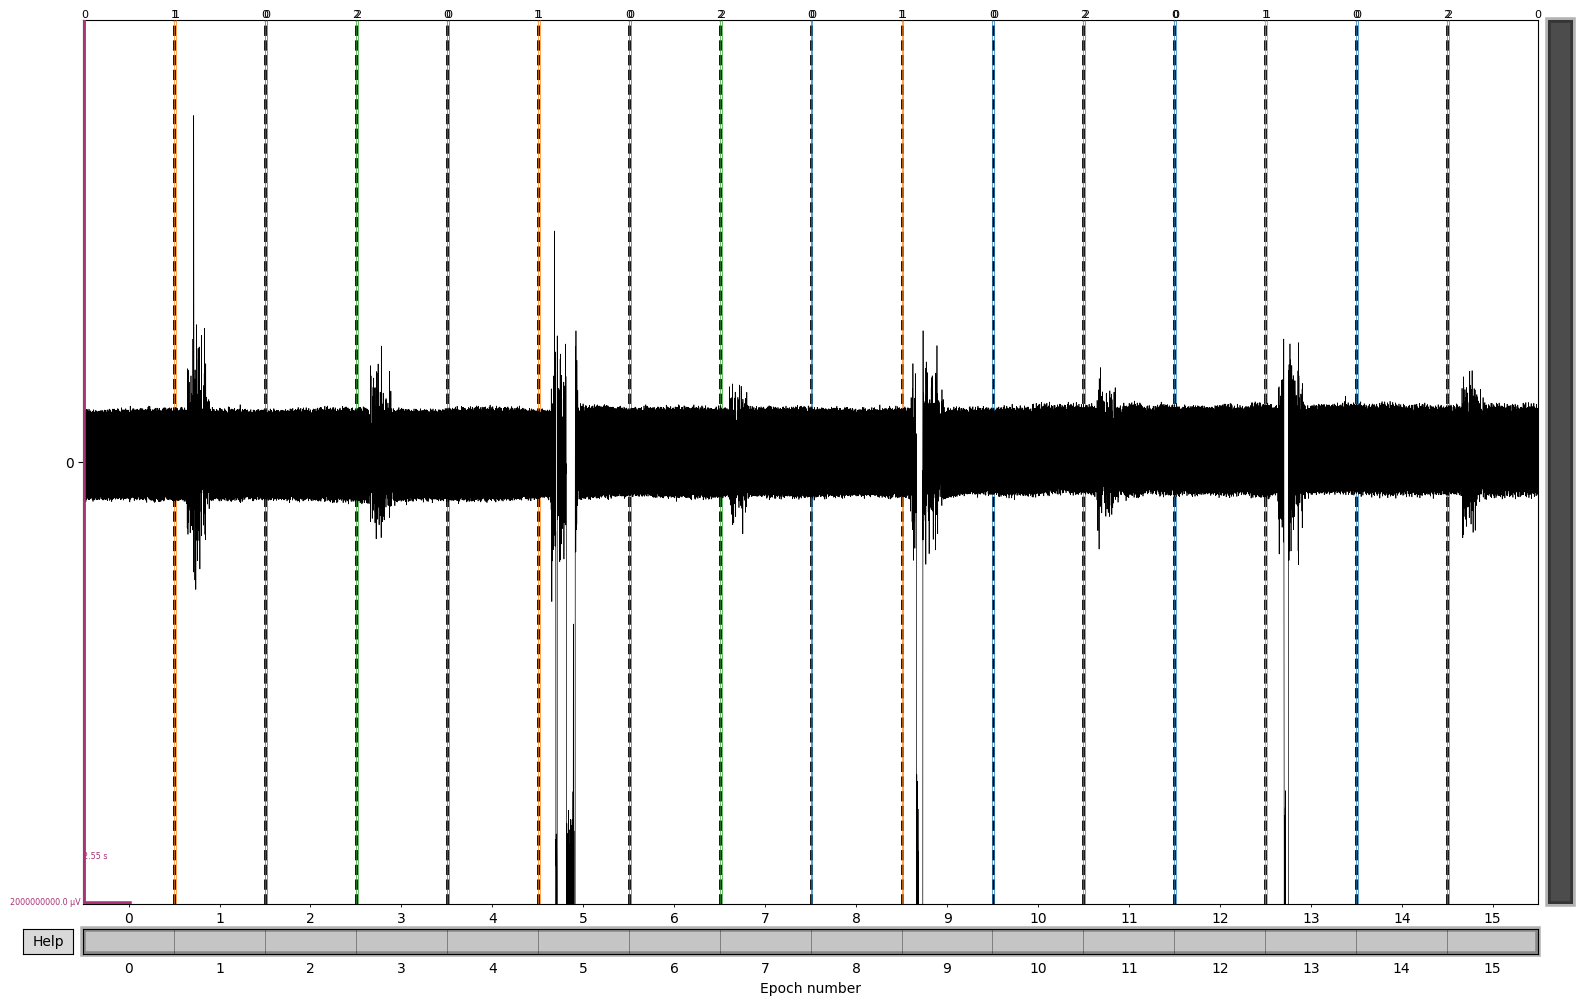

    Using multitaper spectrum estimation with 7 DPSS windows
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


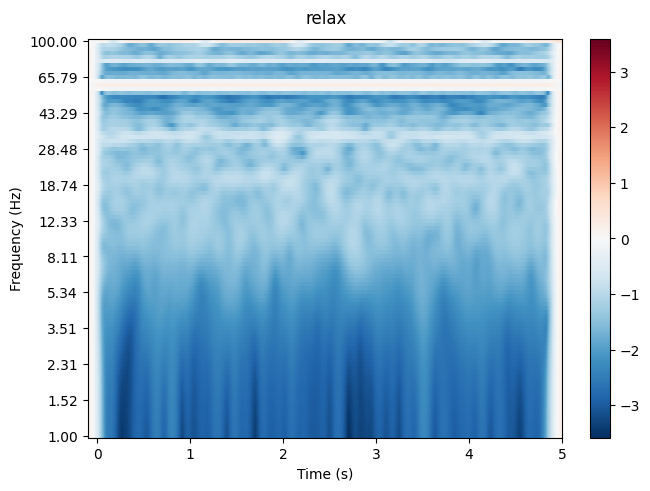

Applying baseline correction (mode: logratio)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


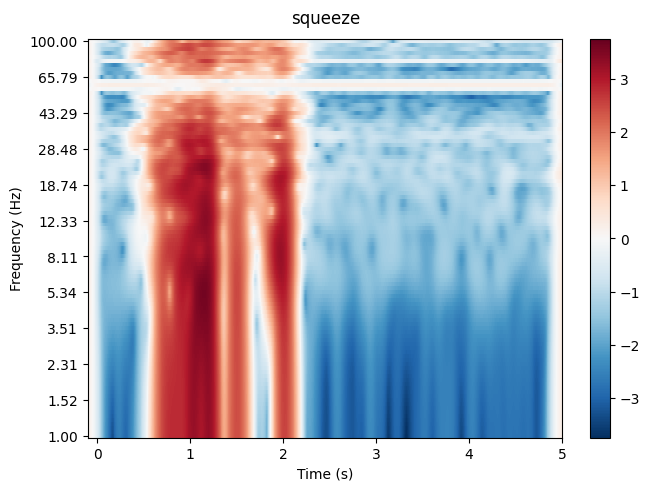

Applying baseline correction (mode: logratio)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


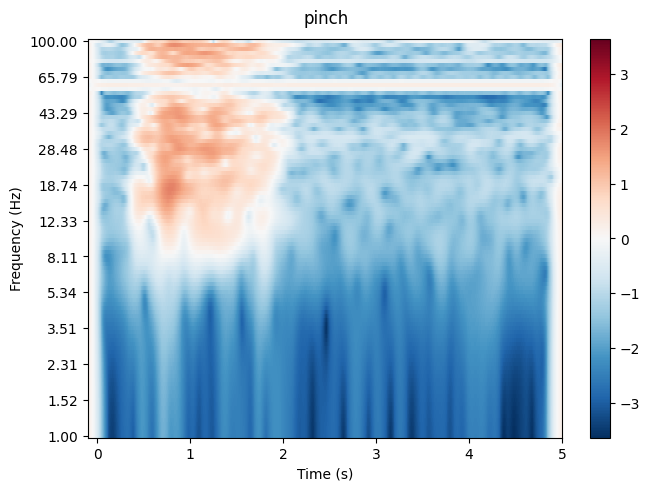

[<Figure size 640x480 with 2 Axes>]

In [52]:
import mne
from pathlib import Path
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
import numpy as np


def load_events(file_path):
        events = np.loadtxt(file_path, delimiter=',', dtype=int)
        return events

def csv_to_dataframe(file):
        # print(BoardIds.GANGLION_BOARD.value)
        # eeg_channels_names = BoardShim.get_eeg_names(BoardIds.GANGLION_BOARD)
        # print(eeg_channels_names)
        eeg_channels_names = [str(i) for i in range(15)]
        df = pd.read_csv(file, usecols = eeg_channels_names).transpose()

        return df

def df_to_raw( df, sfreq=200, ch_types='emg'):
    # eeg_channels_names = BoardShim.get_eeg_names(self.board_id)
    print(df.shape)
    eeg_channels_names = [str(i) for i in range(df.shape[0])]
    ch_types = ['eeg'] * len(eeg_channels_names)

    # Create MNE info object
    info = mne.create_info(ch_names = eeg_channels_names, sfreq = sfreq, ch_types=ch_types)

    # Create MNE raw object
    raw = mne.io.RawArray(df, info)
    raw.load_data()
    # raw.plot(clipping=None, scalings=dict(eeg='1e3', emg='1e5'))

    return raw

def csv_to_raw(file, start_channel=0, end_channel=15):
    df = csv_to_dataframe(file)
    df = df.iloc[start_channel:end_channel, :]
    raw = df_to_raw(df)
    return raw

def raw_to_epochs(raw, event_file, event_dict, tmin=-0.1, tmax=5.0, baseline=None, reject=None):
    events = np.array(load_events(event_file))  
    epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=tmin, tmax=tmax, preload=True, baseline=baseline, reject=reject)
    epochs.plot(scalings=dict(eeg='1e3', emg='1e5'), events=events)
    epochs.compute_psd()
    return epochs

raw = csv_to_raw("data/study2_data.csv", 1, 2)
# events = np.array(load_events("events/study1.txt"))  
event_dict = {"relax": 0, "squeeze": 1, "pinch": 2}
epochs = raw_to_epochs(raw, "events/study2.txt", event_dict)
# epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.1, tmax=5.0, preload=True, baseline=None, reject=r)



# Time frequency analysis
fmax = 100
freqs = np.logspace(*np.log10([1, fmax]), num=fmax)
n_cycles = freqs / 2.0
baseline = (-0.1, 0)

epochs_tfr_relax = epochs["relax"].compute_tfr("morlet", n_cycles=n_cycles, return_itc=False, freqs=freqs, average=True, use_fft=True)
epochs_tfr_relax.plot(title="relax", baseline=baseline, mode="logratio") # vmax=1e-8,

epochs_tfr_squeeze = epochs["squeeze"].compute_tfr("morlet", n_cycles=n_cycles, return_itc=False, freqs=freqs, average=True, use_fft=True)
epochs_tfr_squeeze.plot(title="squeeze", baseline=baseline, mode="logratio") # vmax=1e-8,

epochs_tfr_pinch = epochs["pinch"].compute_tfr("morlet", n_cycles=n_cycles, return_itc=False, freqs=freqs, average=True, use_fft=True)
epochs_tfr_pinch.plot(title="pinch", baseline=baseline, mode="logratio") # vmax=1e-8,

